In [1]:
import psi4
import numpy as np
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
# run across an H2O symmetric bond stretching surface
# 0.5 - 2.0 Angstroms, increments of 0.1
# save geometry, nuclear charges (same across the surface...), and scf energy
psi4.set_options({
    'basis':'sto-3g'
})
geoms = {}
qs = {}
Es = {}
for i in np.arange(0.5,2.1,0.1):
    mol = psi4.geometry("""
    O
    H 1 """ + str(i) + """
    H 1 """ + str(i) + """ 2 104.5
    symmetry c1
    """)
    geoms[i] = mol.geometry().to_array()
    qs[i] = np.array([mol.fZ(i) for i in range(mol.natom())])
    Es[i] = psi4.energy('scf')
    
# question for the student: does it matter whether the output geometry is in Angrstrom or Bohr?
## the output will be in Bohr, though we're using Angstrom as the input. Psi4 is just like that.
## that's okay, because it would just multiply our matrix by a scalar, which would
## multiply our dual-coefficients by that scalar. as long as we're consistent, it doesn't matter!

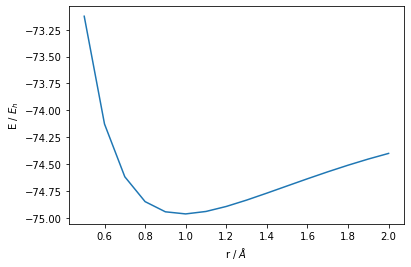

In [3]:
# plt the original surface
plt.plot(np.arange(0.5,2.1,0.1),list(Es.values()))
plt.xlabel('r / $\AA$')
plt.ylabel('E / $E_h$')
plt.show()

In [4]:
# build coulomb matrix according to https://singroup.github.io/dscribe/tutorials/coulomb_matrix.html
couls = {}
for k in np.arange(0.5,2.1,0.1): # loop over all geometries
    couls[k] = np.zeros((len(qs[k]),len(qs[k]))) # n_atom x n_atom matrix
    for i in range(0,len(qs[k])): # n_atom rows
        for j in range(0,len(qs[k])): # n_atom columns
            if i == j:
                couls[k][i][j] = qs[k][i] ** 2.4 / 2.0 # diagonal
            else:
                couls[k][i][j] = qs[k][i] * qs[k][j] / np.linalg.norm(geoms[k][i] - geoms[k][j])

In [5]:
# train a KRR model w/ RBF kernel, wide grid search 3-fold CV w/ NMSE scoring
krr = KernelRidge(kernel='rbf')
parameters = {'alpha':np.logspace(-12,12,num=24),
              'gamma':np.logspace(-12,12,num=24)}
krr_regressor = GridSearchCV(krr,parameters,cv=3,scoring='neg_mean_squared_error')
# need to flatten each representation for skl
krr_regressor.fit([couls[k].flatten() for k in np.arange(0.5,2.1,0.1)],list(Es.values()))

/Users/mash/miniconda3/envs/p4dev/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                   kernel='rbf', kernel_params=None),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-12, 1.10529514e-11, 1.22167735e-10, 1.35031404e-09,
       1.49249555e-08, 1.64964807e-07, 1.82334800e-06, 2.01533769e-05,
       2.22754295e-04, 2.46209240e-03, 2.7213387...
       1.49249555e-08, 1.64964807e-07, 1.82334800e-06, 2.01533769e-05,
       2.22754295e-04, 2.46209240e-03, 2.72133877e-02, 3.00788252e-01,
       3.32459793e+00, 3.67466194e+01, 4.06158599e+02, 4.48925126e+03,
       4.96194760e+04, 5.48441658e+05, 6.06189899e+06, 6.70018750e+07,
       7.40568469e+08, 8.18546731e+09, 9.04735724e+10, 1.00000000e+12])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [6]:
# predict the surface
# should be really good- we trained on all of these geometries, now we're predicting them all!
p = krr_regressor.predict([couls[k].flatten() for k in np.arange(0.5,2.1,0.1)])

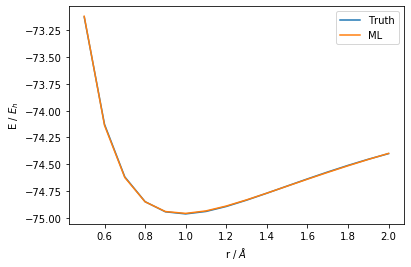

In [7]:
# plot the old and new surfaces together
plt.plot(np.arange(0.5,2.1,0.1),list(Es.values()),label='Truth')
plt.plot(np.arange(0.5,2.1,0.1),p,label='ML')
axes = plt.gca()
plt.legend()
plt.xlabel('r / $\AA$')
plt.ylabel('E / $E_h$')
plt.show()

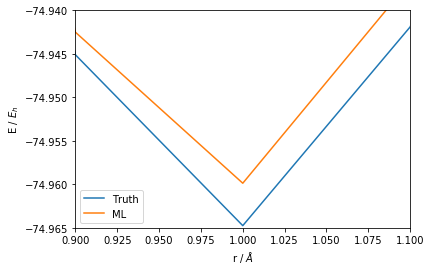

In [8]:
# error is in the mEh range for H2O- let's zoom in
plt.plot(np.arange(0.5,2.1,0.1),list(Es.values()),label='Truth')
plt.plot(np.arange(0.5,2.1,0.1),p,label='ML')
axes = plt.gca()
axes.set_xlim([0.9,1.1])
axes.set_ylim([-74.965,-74.94])
plt.legend()
plt.xlabel('r / $\AA$')
plt.ylabel('E / $E_h$')
plt.show()